# Personality Classifier Notebook

## Notebook Default Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../hatstall/')

## Pipeline System

### Pipeline Imports

In [2]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline as ModelPipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from hatstall.pipes import Pipeline as CustomPipeline, PipelineSystem
from hatstall.pipes.engineer import PostsJoiner, AverageWordCalculator, Debugger
from hatstall.pipes.model import Evaluator, TestDataTokenChecker
from hatstall.pipes.loader import PersonalityPostLoader
from hatstall.pipes.preparator import (
    PostsSplitter, EvenlyDistributor, TrainTestSplitter, DigitReplacer, LinkReplacer,
    PersonalityCodeReplacer)

### Base Pipeline System

In [3]:
PreparationPipeline = CustomPipeline
EvaluationPipeline = CustomPipeline

psystem = PipelineSystem([
    ('preperation', PreparationPipeline([
        ('loader', PersonalityPostLoader),
        ('splitter', PostsSplitter),
        ('persona', PersonalityCodeReplacer),
        ('evenfier', EvenlyDistributor),
        ('traintest', TrainTestSplitter)
    ])),
    ('modelling', ModelPipeline([
        ('joiner', PostsJoiner()),
        ('vect', TfidfVectorizer(max_df=1., min_df=0.01)),
        ('log', LogisticRegression(random_state=123)),
    ])),
    ('evaluation', EvaluationPipeline([
        ('eval', Evaluator)
    ]))
])
psystem.run()

--- Running preparation pipeline ---
Running loader pipe --> PersonalityPostLoader
Running splitter pipe --> PostsSplitter
Ignored 5624 texts because of too small chunks
Running persona pipe --> PersonalityCodeReplacer
Running evenfier pipe --> EvenlyDistributor
Running traintest pipe --> TrainTestSplitter
Train size: Counter({'Introvert': 6728, 'Extrovert': 6727})
Test size: Counter({'Extrovert': 2884, 'Introvert': 2883})
--- Running modelling pipeline ---
--- Running evaluation pipeline ---
Running eval pipe --> Evaluator
0.6216403676088087
[0.6259856  0.61719298]
[[1826 1057]
 [1125 1759]]


### Advanced Pipeline System

In [4]:
PreparationPipeline = CustomPipeline
EvaluationPipeline = CustomPipeline

psystem = PipelineSystem([
    ('preperation', PreparationPipeline([
        ('loader', PersonalityPostLoader),
        ('splitter', PostsSplitter),
        ('persona', PersonalityCodeReplacer),
        ('link', LinkReplacer),
        ('digit', DigitReplacer), 
        ('evenfier', EvenlyDistributor),
        ('traintest', TrainTestSplitter)
    ])),
    ('modelling', ModelPipeline([
        ('features', FeatureUnion([
            ('token', ModelPipeline([
                ('joiner', PostsJoiner()),
                ('vect', TfidfVectorizer(
                    max_df=1.0, min_df=0.01,
                    token_pattern='(?u)\\$?\\b\\w\\w+\\b')),
            ])),
            ('mean_word', ModelPipeline([
                ('average', AverageWordCalculator()),
                ('scaler', MinMaxScaler())
            ])),
        ])),
        ('log', LogisticRegression(random_state=123)),
    ])),
    ('evaluation', EvaluationPipeline([
        ('eval', Evaluator)
    ]))
])
psystem.run()

--- Running preparation pipeline ---
Running loader pipe --> PersonalityPostLoader
Running splitter pipe --> PostsSplitter
Ignored 5624 texts because of too small chunks
Running persona pipe --> PersonalityCodeReplacer
Running link pipe --> LinkReplacer
Running digit pipe --> DigitReplacer
Running evenfier pipe --> EvenlyDistributor
Running traintest pipe --> TrainTestSplitter
Train size: Counter({'Introvert': 6728, 'Extrovert': 6727})
Test size: Counter({'Extrovert': 2884, 'Introvert': 2883})
--- Running modelling pipeline ---
--- Running evaluation pipeline ---
Running eval pipe --> Evaluator
0.623547771805098
[0.62601206 0.62105079]
[[1817 1066]
 [1105 1779]]


## Feature Chi Analysis

In [5]:
from sklearn.feature_selection import chi2

pl_container = psystem.pipeline_containers[2]
X, y, _, _ = pl_container.pipeline.payload['train_test']

model = pl_container.pipeline.payload['model']
matrix = model.named_steps['features'].transform(X)

feature_pipe = model.named_steps['features']
token_pipe = [x for x in feature_pipe.transformer_list if x[0] == 'token'][0][1]
feature_names = token_pipe.named_steps['vect'].get_feature_names()
feature_names = feature_names + ['$average_word_count']

chi = chi2(matrix, y)

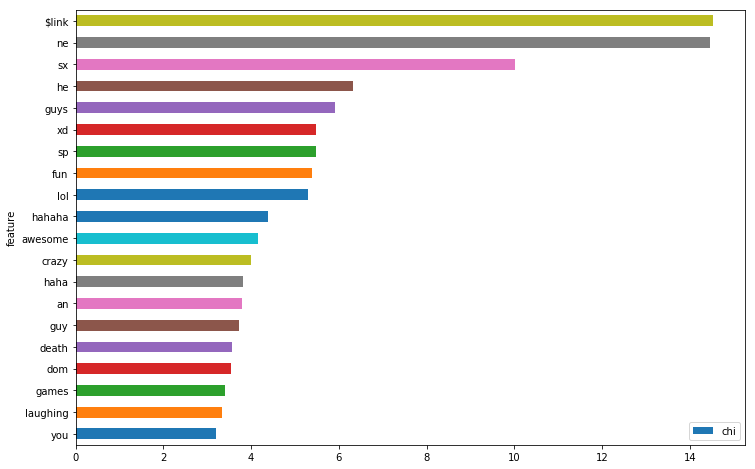

In [7]:
chidf = pd.DataFrame({'chi': chi[0], 'feature': feature_names})
chidf.sort_values('chi', ascending=False, inplace=True)
chidf.iloc[:20].iloc[::-1].plot(x='feature', y='chi', kind='barh', figsize=(12, 8))